In [ ]:
## Notebook env: mirtud_env (R kernel)
## this notebook finds expression patterns in aggregated datasets

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(escape))
suppressMessages(library(dittoSeq))
suppressMessages(library(GSEABase))
suppressMessages(library(SummarizedExperiment))

In [2]:
tRF_loaded_seuratobj <- readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_normalized_integrated_seurat.rds')
meta = tRF_loaded_seuratobj@meta.data

meta$guide[str_sub(meta$guide, 1, 3) == 'TuD'] <- 'TuD_NC'
tRF_loaded_seuratobj@meta.data <- meta

Warning message:
“Removed 36 rows containing non-finite values (`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


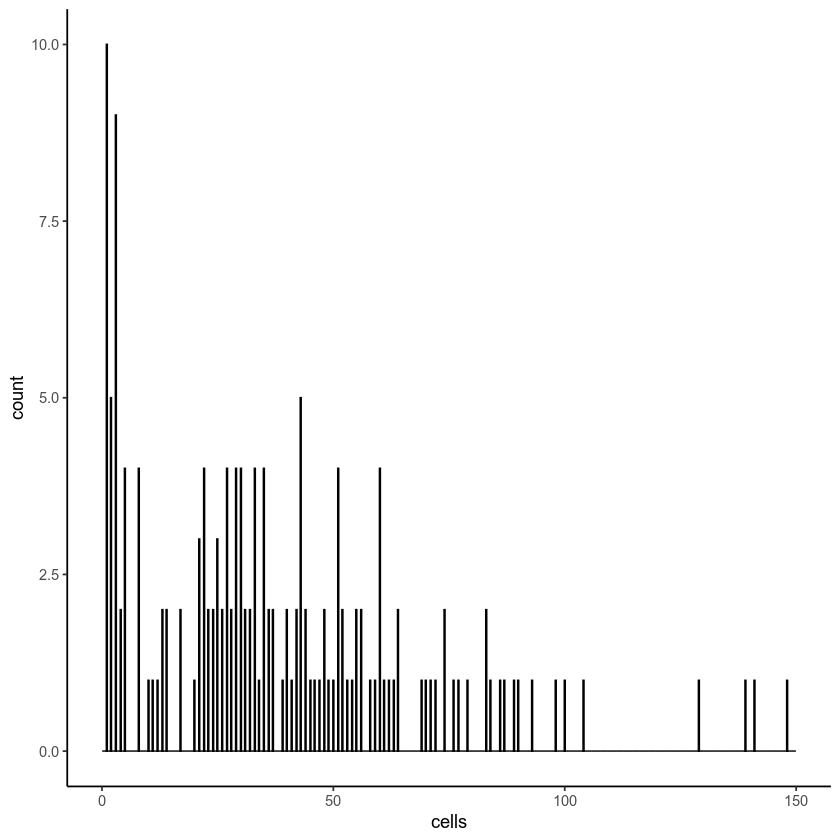

In [3]:
count_df = data.frame(guide = names(table(meta$guide)), cells = as.numeric(table(meta$guide)))
ggplot(count_df, aes(x = cells)) + geom_histogram(color="black", fill="white", position = "identity", bins = 1000) + 
xlim(0,150) + theme_classic()

In [4]:
suppressMessages(library(dplyr))
cbind(arrange(count_df, cells)[1:10,], arrange(count_df, -cells)[1:10,])

,guide,cells,guide,cells
,<chr>,<dbl>,<chr>,<dbl>
1,tRF_Leu_CAA.CAG_2,1,TuD_NC,7753
2,tRNA-Arg-TCG-2-1.3t,1,tRF_Ala_TGC.AGC_6,598
3,tRNA-Cys-GCA-4-1.3t,1,tRF_Asn_GTT_2,501
4,tRNA-Gln-CTG-(5)1-1.1t,1,tRF_Ala_CGC.AGC.TGC_5,477
5,tRNA-Lys-TTT-(5)3-1.1t,1,tRF_Gly_CCC_2,469
6,tRNA-Met-CAT-(2)3-1.1t,1,tRF_Lys_CTT_2,425
7,tRNA-Val-AAC-3-1.3t,1,tRF_Leu_TAA_2,390
8,tRNA-Val-CAC-2-1.3t,1,tRF_Gly_TCC_4,377
9,tRNA-Val-CAC-3-1.3t,1,tRF_Ser_CGA_2,333


In [5]:
length(count_df$guide)

[1] 196

In [6]:
## Glu, Asp, Gly, Tyr  -- create fragments that perturb YBX1 binding and stabilization of mRNA
grep('Glu|Asp|Gly|Tyr', count_df$guide, value = TRUE)

[1] "tRF_Asp_GTC_2"           "tRF_Glu_CTC_2"          
 [3] "tRF_Glu_TTC_2"           "tRF_Glu_TTC_4"          
 [5] "tRF_Gly_CCC_2"           "tRF_Gly_GCC_2"          
 [7] "tRF_Gly_GCC.CCC_4"       "tRF_Gly_TCC_2"          
 [9] "tRF_Gly_TCC_4"           "tRF_Tyr_GTA_2"          
[11] "tRNA-Asp-GTC-(11)2-1.1t" "tRNA-Asp-GTC-(11)2-1.2t"
[13] "tRNA-Asp-GTC-(11)2-1.lh" "tRNA-Glu-CTC-(7)1-1.2t" 
[15] "tRNA-Gly-CCC-(2)1-1.2t"  "tRNA-Gly-CCC-(2)2-1.2t" 
[17] "tRNA-Gly-CCC-3-1.2t"     "tRNA-Gly-GCC-(6)2-1.2t" 
[19] "tRNA-Gly-GCC-5-1.2t"     "tRNA-Gly-TCC-(6)2-1.2t" 
[21] "tRNA-Gly-TCC-4-1.2t"     "tRNA-Tyr-GTA-2-1.2t"    
[23] "tRNA-Tyr-GTA-2-1.lh"

In [7]:
### seems like # of cells per guide is a huge covariate in expression (based on heatmap below without regressing it out)
## so need to control for it here
cell_guide_count = 1:nrow(meta)
for (i in 1:nrow(count_df)){
    cell_guide_count[meta$guide == count_df$guide[i]] = count_df$cells[i]
}

meta$cell_guide_count = cell_guide_count
tRF_loaded_seuratobj@meta.data <- meta

In [ ]:
tRF_seuratobj = CreateSeuratObject(tRF_loaded_seuratobj@assays$RNA@counts, meta.data = tRF_loaded_seuratobj@meta.data)
tRF_seuratobj = NormalizeData(tRF_seuratobj)
saveRDS(tRF_seuratobj, '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/tRF_seuratobj_from_pseudobulk_pathway_analysis_tRF_nb.rds')

In [9]:
tRF_seuratobj_rel_norlmalized = CreateSeuratObject(tRF_loaded_seuratobj@assays$RNA@counts, meta.data = tRF_loaded_seuratobj@meta.data)
tRF_seuratobj_rel_norlmalized = NormalizeData(tRF_seuratobj_rel_norlmalized, normalization.method = 'RC')

In [10]:
#tRF_seuratobj = ScaleData(tRF_seuratobj, features = rownames(tRF_seuratobj), vars.to.regress = c('sample', 'percent.mt', 'nCount_RNA', 'cell_guide_count'))

In [11]:
Pseudo_bulk_exp = AverageExpression(tRF_seuratobj, assays = "RNA", group.by = "guide", slot = "data")
Pseudo_bulk_exp = Pseudo_bulk_exp[['RNA']]

Pseudo_bulk_exp_counts = AverageExpression(tRF_seuratobj, assays = "RNA", group.by = "guide", slot = "counts")
Pseudo_bulk_exp_counts = Pseudo_bulk_exp_counts[['RNA']]

In [12]:
Pseudo_bulk_exp_RC = AverageExpression(tRF_seuratobj_rel_norlmalized, assays = "RNA", group.by = "guide", slot = "data")
Pseudo_bulk_exp_RC = Pseudo_bulk_exp_RC[['RNA']]

Warning message in PseudobulkExpression(object = object, pb.method = "average", :
“Exponentiation yielded infinite values. `data` may not be log-normed.”


In [13]:
GS.hallmark <- getGeneSets(library = "H")
GS.hallmark = geneIds(GS.hallmark)

In [14]:
genes_present_in_set = vector(length = length(GS.hallmark))
for (i in 1:length(GS.hallmark)){
    genes_present_in_set[i] = length(which(GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp)))
}

geneset_gene_counts_df = data.frame(gene_set = names(GS.hallmark), genes_present = genes_present_in_set)




In [15]:
suppressMessages(library(dplyr))
geneset_gene_counts_df %>% arrange(genes_present) %>% head()

,gene_set,genes_present
,<chr>,<int>
1,HALLMARK_PANCREAS_BETA_CELLS,28
2,HALLMARK_ANGIOGENESIS,31
3,HALLMARK_NOTCH_SIGNALING,31
4,HALLMARK_HEDGEHOG_SIGNALING,34
5,HALLMARK_APICAL_SURFACE,38
6,HALLMARK_WNT_BETA_CATENIN_SIGNALING,39


## Heatmaps of gene set expression

In [16]:
genesetexp_x_guide = matrix(0, nrow = length(GS.hallmark), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(GS.hallmark), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(GS.hallmark)){
        genes = GS.hallmark[[i]][GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

In [17]:
mean(range(genesetexp_x_guide))

[1] 4.333373

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



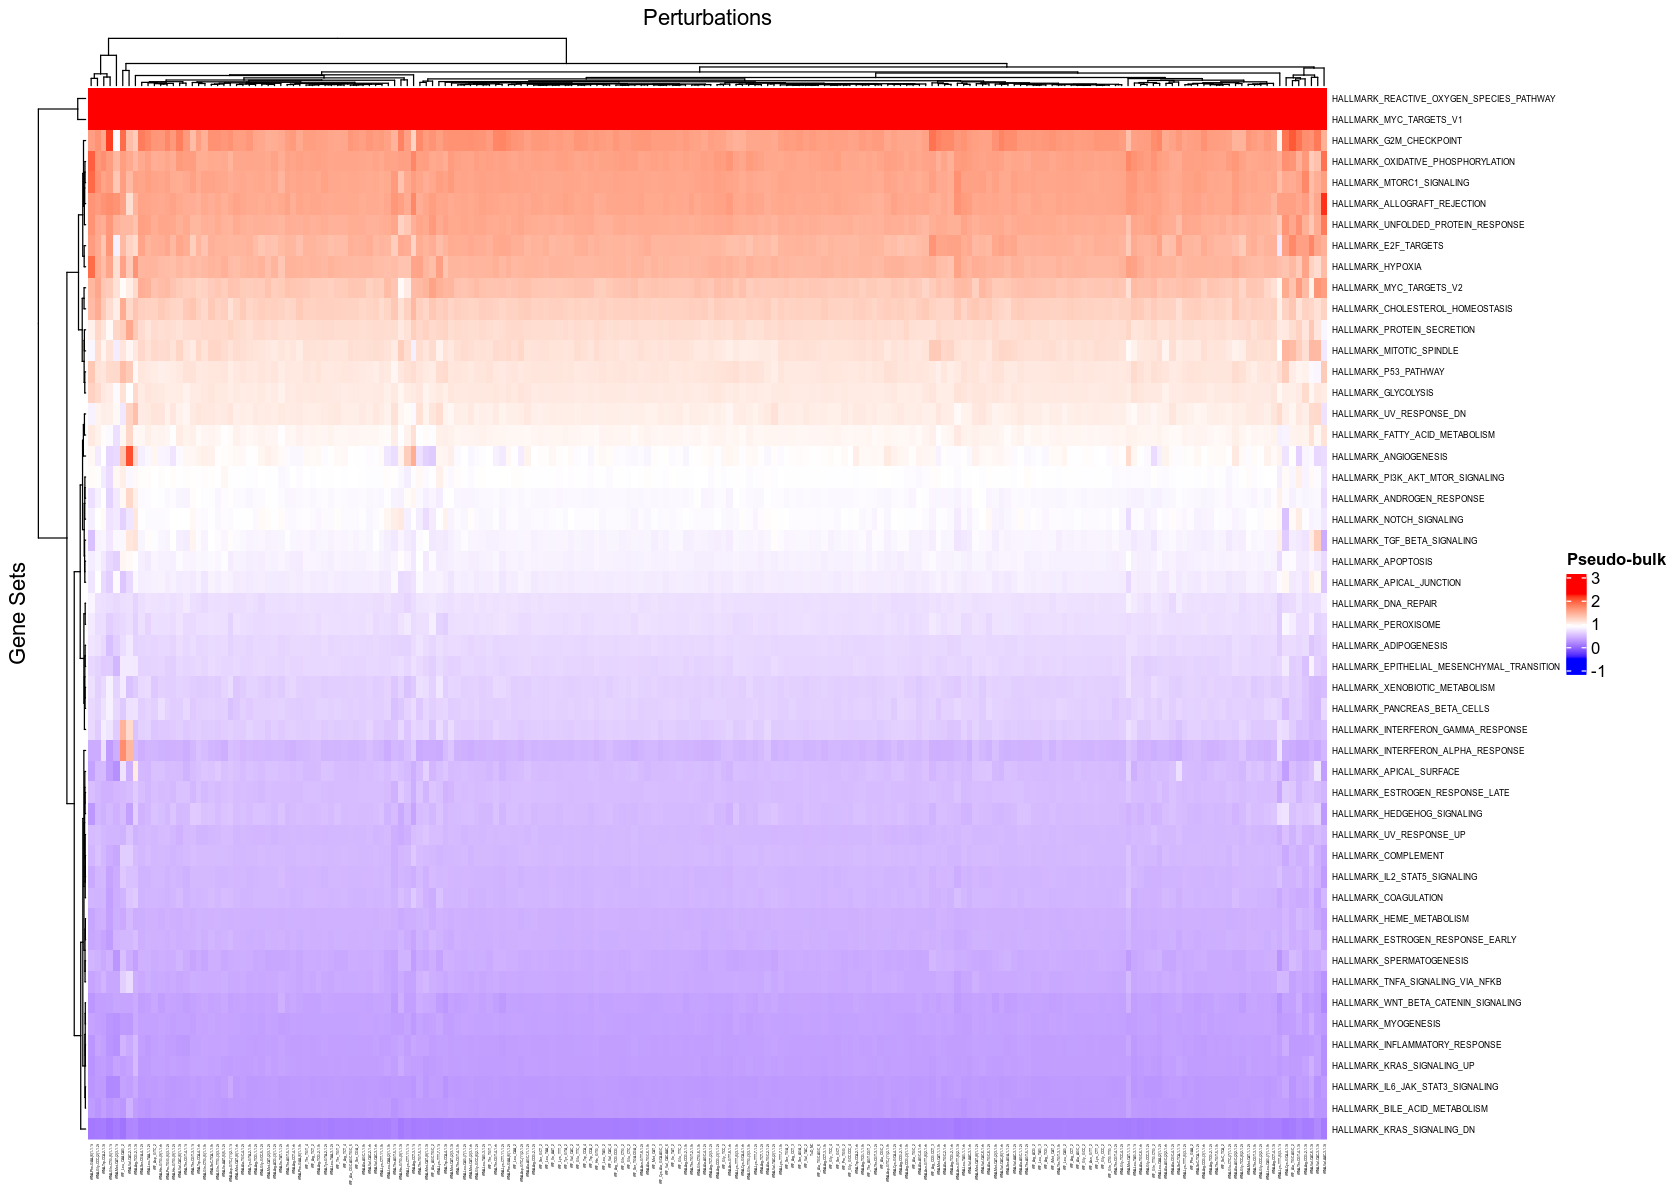

In [18]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))

avg = mean(genesetexp_x_guide)
lower_bound = mean(genesetexp_x_guide) - 2*sd(genesetexp_x_guide)
upper_bound = mean(genesetexp_x_guide) + 2*sd(genesetexp_x_guide)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Gene Sets', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 5)))
}

options(repr.plot.width = 14, repr.plot.height = 10)

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_hallmark_htmap_tRF.pdf', width = 12, height = 11)
perturb_htmp(genesetexp_x_guide, 'Pseudo-bulk')
dev.off()

perturb_htmp(genesetexp_x_guide, 'Pseudo-bulk')



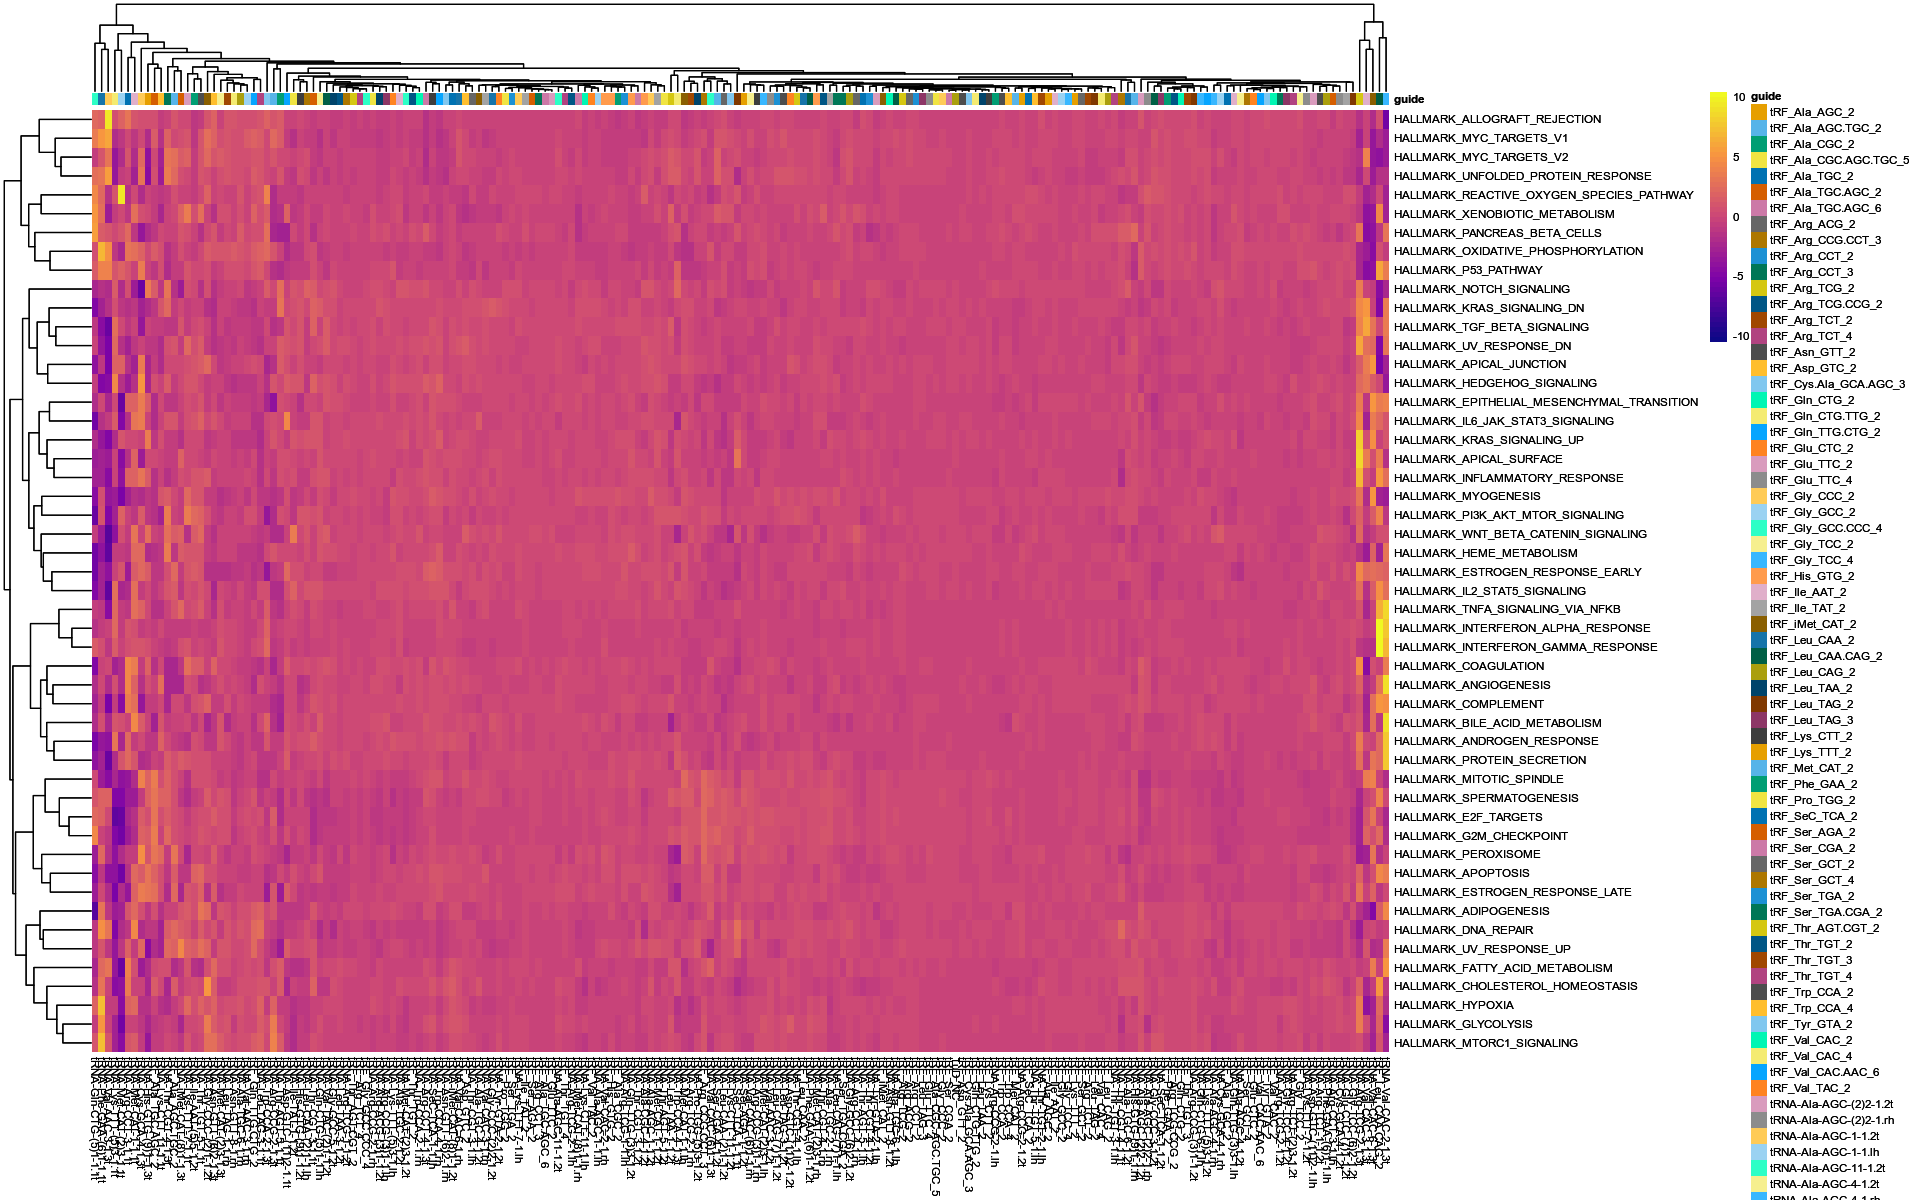

In [19]:
## better heatmap (using pheatmap and better color scheme)
coldat = cbind(guide = colnames(Pseudo_bulk_exp_counts), t(genesetexp_x_guide))
coldat = as.data.frame(coldat)
rownames(coldat) = colnames(Pseudo_bulk_exp_counts)
coldat[, 2:ncol(coldat)] <- apply(coldat[, -1], 2, as.numeric)

bulkSE <- SummarizedExperiment(assays = list(counts = Pseudo_bulk_exp_counts,
             logcounts = Pseudo_bulk_exp), colData = coldat)

colors <- colorRampPalette(c("#0D0887FF","#7E03A8FF","#CC4678FF","#F89441FF","#F0F921FF"))
options(repr.plot.width = 16, repr.plot.height = 10)


htmp = dittoHeatmap(bulkSE, genes = NULL, metas = as.character(rownames(genesetexp_x_guide)), 
             annot.by = "guide", order.by = "guide", 
             fontsize = 7, 
             cluster_cols = TRUE,
             heatmap.colors = colors(50))

htmp

In [20]:
save_pheatmap_pdf <- function(x, filename, width=30, height=12) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

save_pheatmap_pdf(htmp, "/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_hallmark_htmap2_tRF.pdf")

png 
  2

## Heatmaps of gene set fold change expression to TuD_NC

In [21]:
class(genesetexp_x_guide)

[1] "matrix" "array"

In [22]:
tmp_df = as.data.frame(genesetexp_x_guide)
genesetexp_x_guide_FC = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC = as.matrix(genesetexp_x_guide_FC)

In [23]:
range(genesetexp_x_guide_FC)

[1] 0.4454264 3.8086815

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



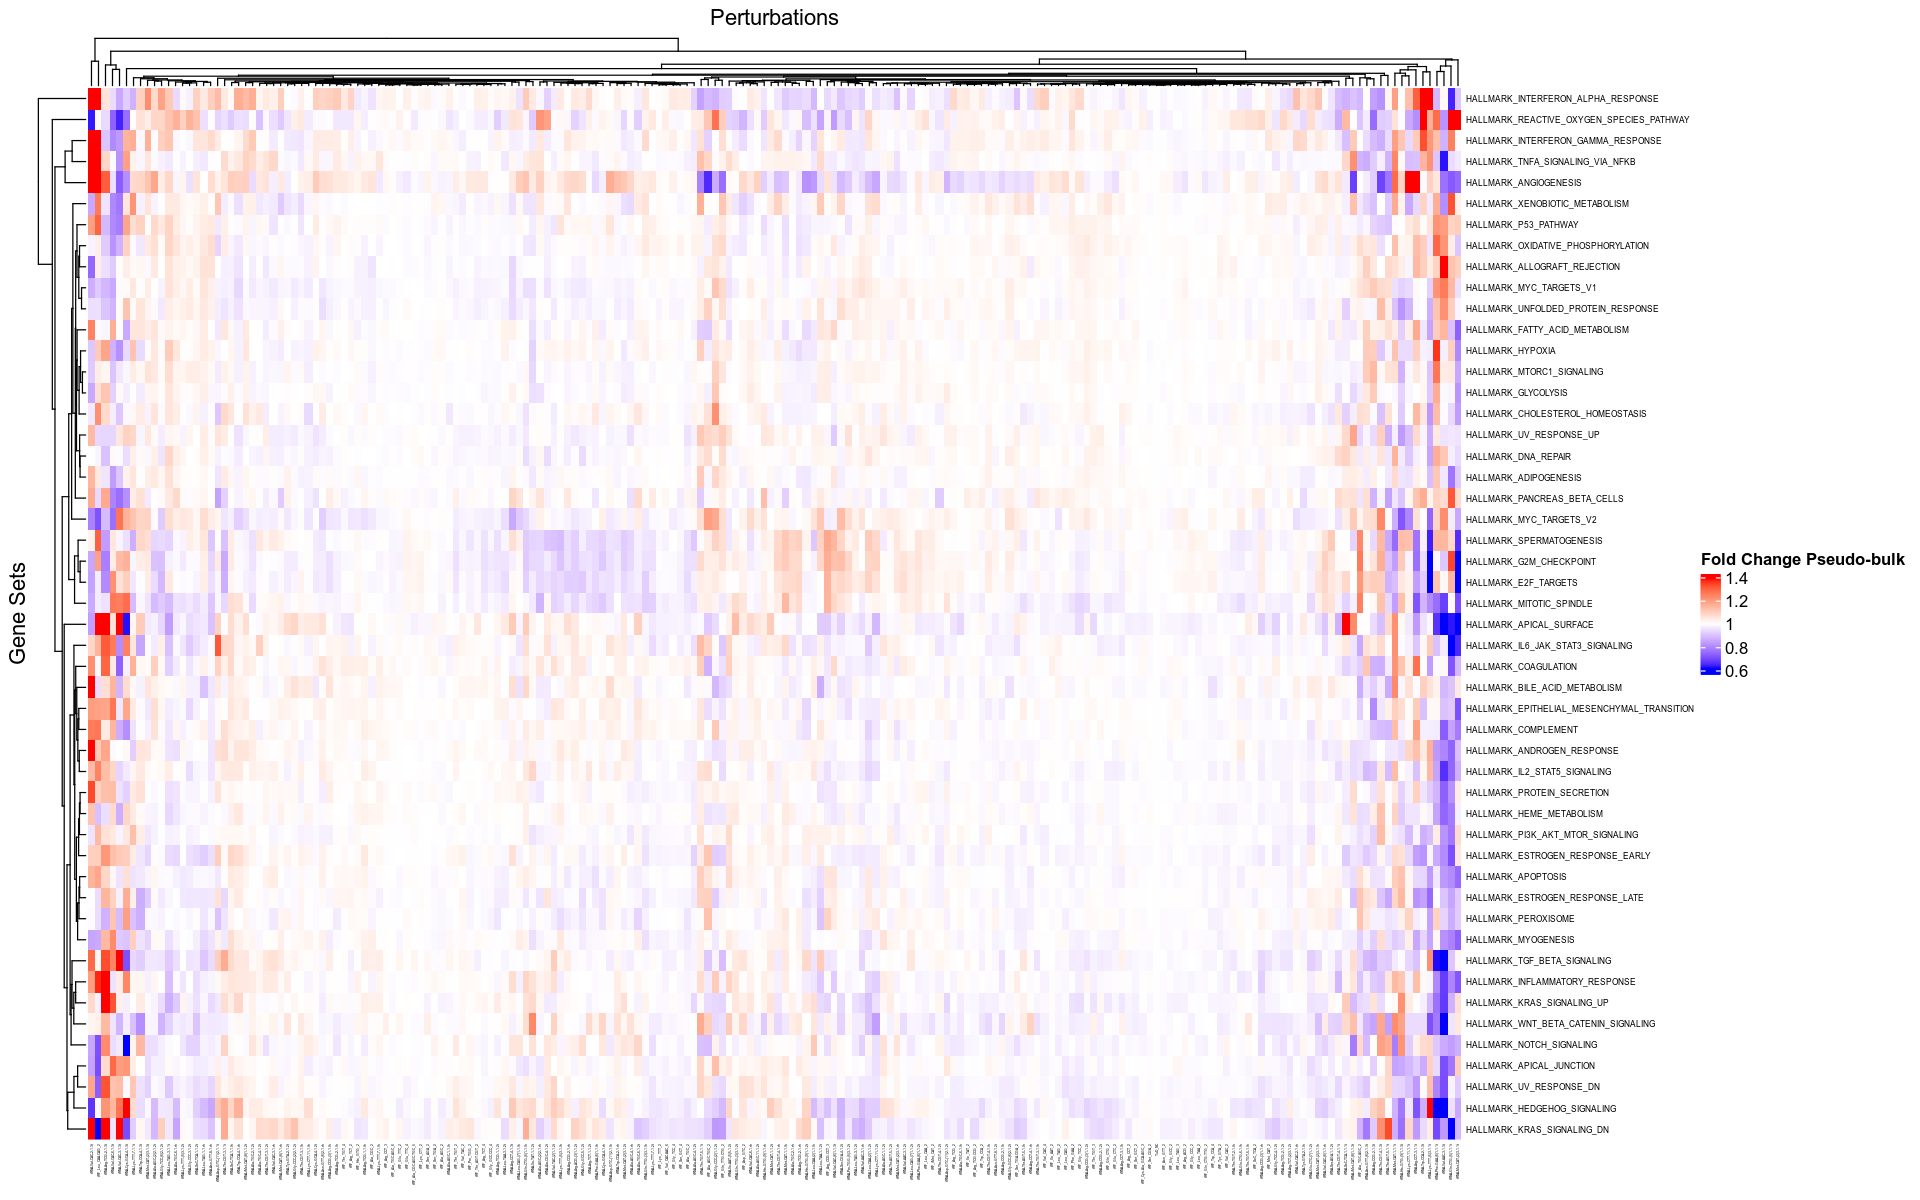

In [33]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))

avg = mean(genesetexp_x_guide_FC)
lower_bound = mean(genesetexp_x_guide_FC) - 5*sd(genesetexp_x_guide_FC)
upper_bound = mean(genesetexp_x_guide_FC) + 5*sd(genesetexp_x_guide_FC)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Gene Sets', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 5)))
}

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_foldchange_hallmark_htmap_tRF.pdf', width = 12, height = 11)
perturb_htmp(genesetexp_x_guide_FC, 'Fold Change Pseudo-bulk')
dev.off()

perturb_htmp(genesetexp_x_guide_FC, 'Fold Change Pseudo-bulk')

In [34]:
saveRDS(genesetexp_x_guide_FC, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/tRF_hallmark_heatmap.rds')

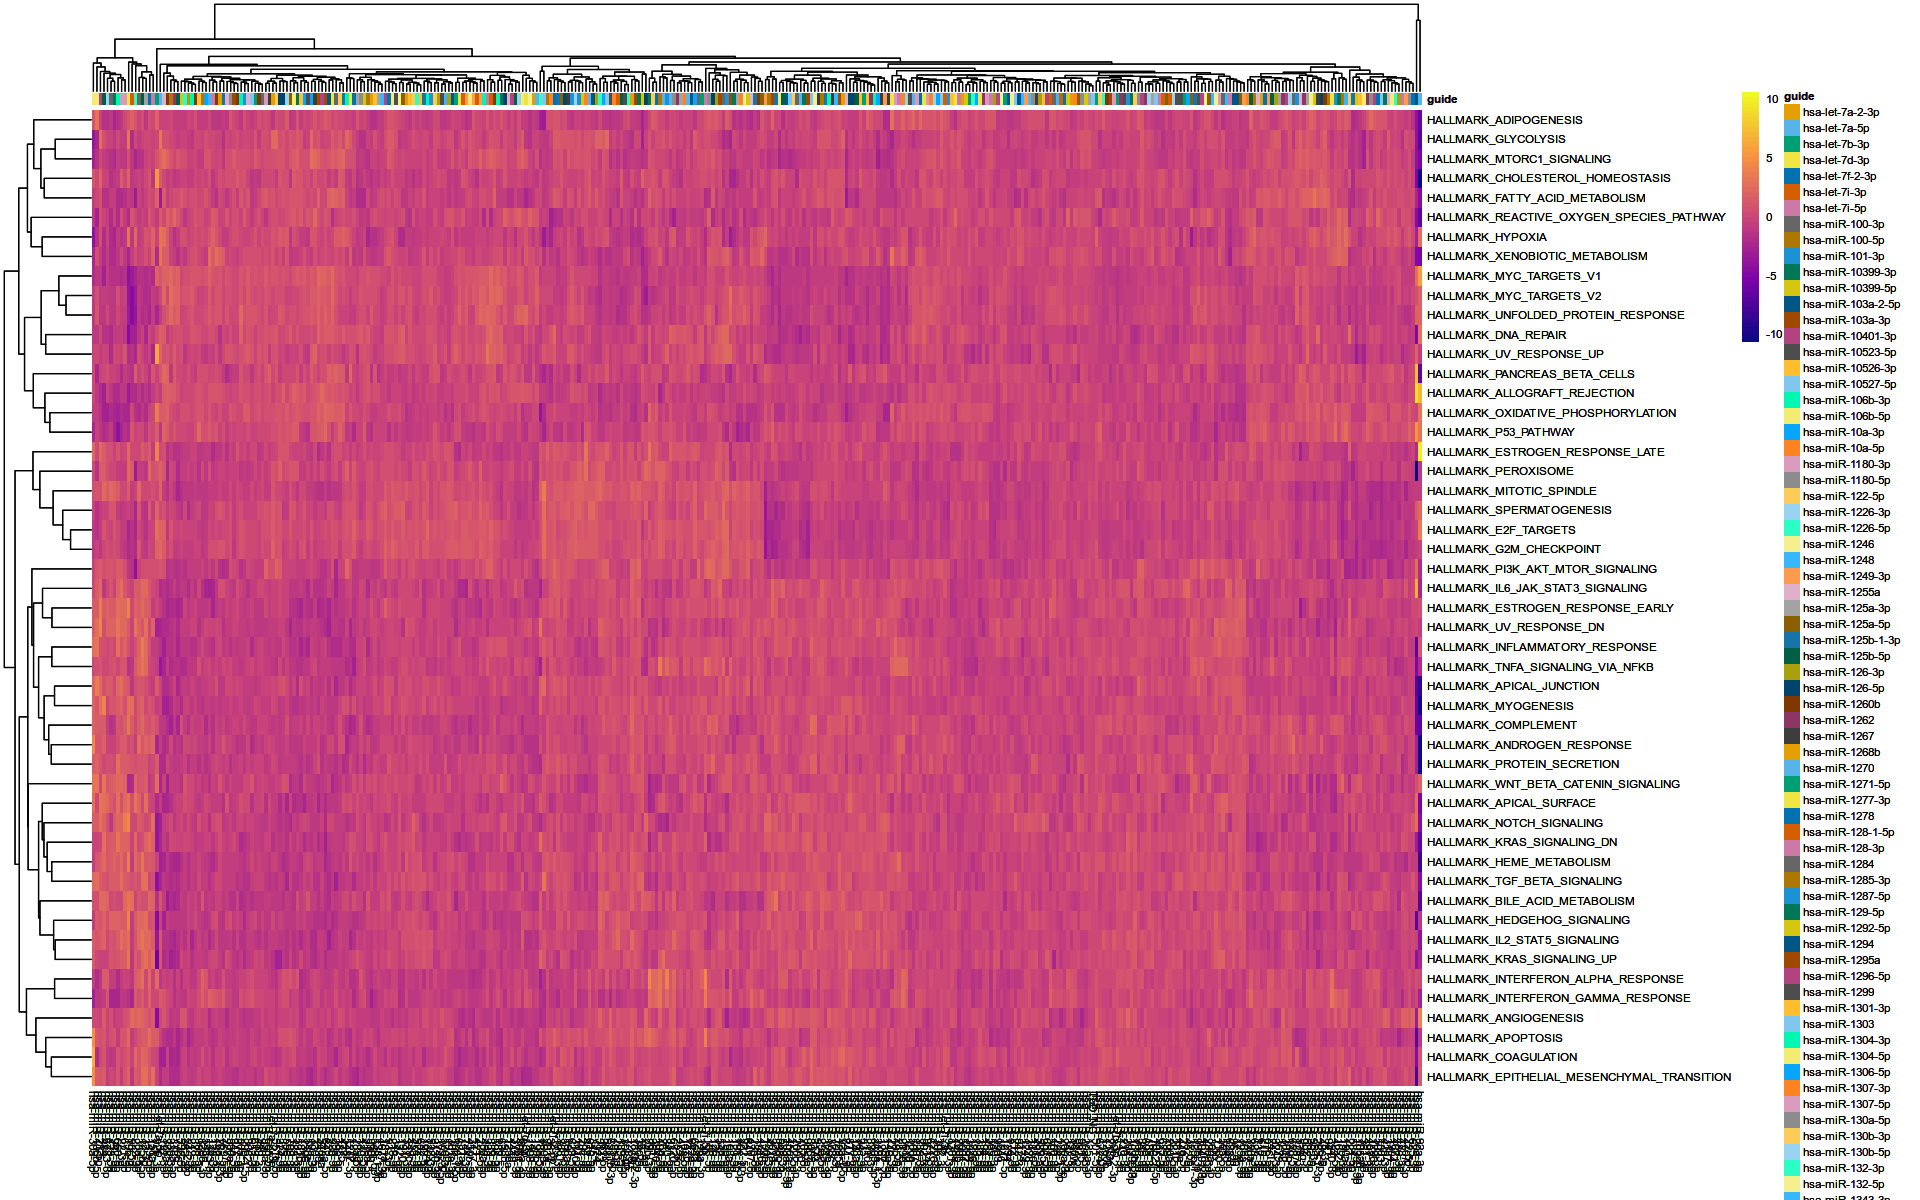

In [31]:
## better heatmap (using pheatmap and better color scheme)
coldat = cbind(guide = colnames(Pseudo_bulk_exp_counts), t(genesetexp_x_guide_FC))
coldat = as.data.frame(coldat)
rownames(coldat) = colnames(Pseudo_bulk_exp_counts)
coldat[, 2:ncol(coldat)] <- apply(coldat[, -1], 2, as.numeric)

bulkSE2 <- SummarizedExperiment(assays = list(counts = Pseudo_bulk_exp_counts,
             logcounts = Pseudo_bulk_exp), colData = coldat)

colors <- colorRampPalette(c("#0D0887FF","#7E03A8FF","#CC4678FF","#F89441FF","#F0F921FF"))
options(repr.plot.width = 16, repr.plot.height = 10)


htmp = dittoHeatmap(bulkSE2, genes = NULL, metas = as.character(rownames(genesetexp_x_guide_FC)), 
             annot.by = "guide", order.by = "guide", assay = 'logcounts',
             fontsize = 7, 
             cluster_cols = TRUE,
             heatmap.colors = colors(50))

htmp

In [ ]:
### try averaging addmodule score across guides for each module and create heatmap

In [ ]:
dittoHeatmap(bulkSE,
             annot.by = "guide", order.by = "guide", 
             fontsize = 7, 
             cluster_cols = TRUE,
             heatmap.colors = colors(50))

In [23]:
coldat

,guide,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,⋯,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a-2-3p,hsa-let-7a-2-3p,0.9906466,1.0012804,0.9939497,0.9948750,1.0061751,0.9546657,0.9991310,0.9714325,1.0076466,⋯,1.0036951,1.0311415,1.0507027,0.9675038,0.9719565,1.0071557,0.9805433,1.0126245,0.9767188,1.0226259
hsa-let-7a-5p,hsa-let-7a-5p,0.9993857,0.9925544,0.9867788,1.0168072,0.9957564,0.9522341,0.9982078,1.0229751,1.0338907,⋯,0.9712687,1.0757115,1.0109376,0.9253117,0.9154831,0.9929050,0.9405209,1.0357797,0.9192996,1.0758397
hsa-let-7b-3p,hsa-let-7b-3p,0.9974106,0.9970834,0.9987107,1.0755640,0.9795661,1.0194141,1.0150069,1.0249662,0.9999329,⋯,0.9945304,1.0275984,1.0199094,1.0232265,1.0169061,0.9745303,1.0012939,0.9841162,0.9688401,0.9897676
hsa-let-7d-3p,hsa-let-7d-3p,0.9927127,1.0225206,0.9697723,0.9296488,0.9737881,0.9426661,0.9837289,0.9759210,0.9860771,⋯,1.0064018,1.0295862,0.9599114,0.9505084,1.0100907,1.0409073,1.0128654,1.0073743,0.9654838,1.0316417
hsa-let-7f-2-3p,hsa-let-7f-2-3p,1.0160233,0.9989913,1.0128666,0.9618598,1.0356738,0.9509249,1.0327850,1.0015137,1.0082544,⋯,1.0080908,0.9089223,1.0577893,1.0197997,1.0168592,0.9994931,1.0029896,1.0249084,0.9956579,0.9819853
hsa-let-7i-3p,hsa-let-7i-3p,1.0146605,1.0180949,1.0293631,0.9936042,1.0070082,0.9810355,1.0167877,0.9792882,1.0201749,⋯,0.9897051,0.9660880,0.9536214,1.0047775,1.0246265,1.0014462,1.0088786,0.9832722,0.9843777,1.0084271
hsa-let-7i-5p,hsa-let-7i-5p,1.0118324,1.0008753,1.0221362,0.9975289,1.0090697,0.9198218,1.0733850,0.9707156,1.0144991,⋯,1.0238859,0.9903616,1.0831968,1.0006761,1.0695677,1.0188628,0.9751441,0.9887022,1.0507357,0.9625349
hsa-miR-100-3p,hsa-miR-100-3p,1.0154172,0.9898252,1.0031020,0.9671334,0.9907320,0.9663273,1.0038842,0.9981809,0.9959968,⋯,0.9986771,0.9545828,1.0065380,0.9857094,1.0033098,1.0162998,0.9904683,1.0118396,1.0281067,1.0151811
hsa-miR-100-5p,hsa-miR-100-5p,1.0048784,0.9606546,0.9944874,1.1312986,0.9796211,1.0324322,1.0170534,1.0263661,0.9855528,⋯,0.9987853,0.9899419,1.0483004,0.9991821,1.0848724,1.0020638,1.0088220,0.9962938,0.9482563,1.0349953
